<a href="https://colab.research.google.com/github/maskees/project-py/blob/main/Gaussian_mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import k_means
from sklearn import datasets

In [ ]:
iris=datasets.load_iris()
k_means(iris.data,n_clusters=3)

(array([[5.88360656, 2.74098361, 4.38852459, 1.43442623],
        [6.85384615, 3.07692308, 5.71538462, 2.05384615],
        [5.006     , 3.428     , 1.462     , 0.246     ]]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32),
 78.85566582597727)

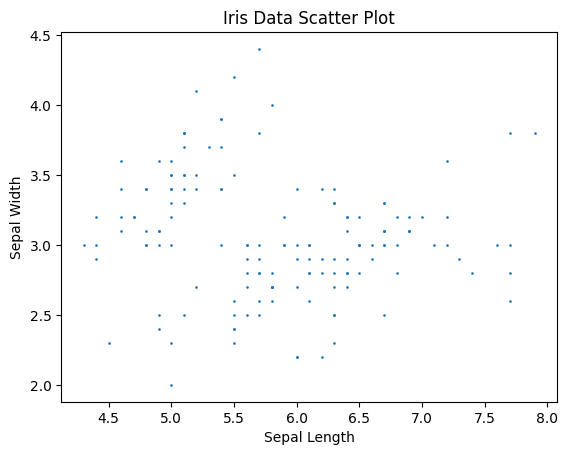

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(iris.data[:, 0], iris.data[:, 1], s=0.8)
plt.title("Iris Data Scatter Plot")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(iris.data)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x7fa6c5191300>)

In [ ]:
import pandas as pd
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
8,3,tied,232.772741
7,2,tied,235.422132
19,2,full,237.056870
18,1,full,240.046015
6,1,tied,240.046015


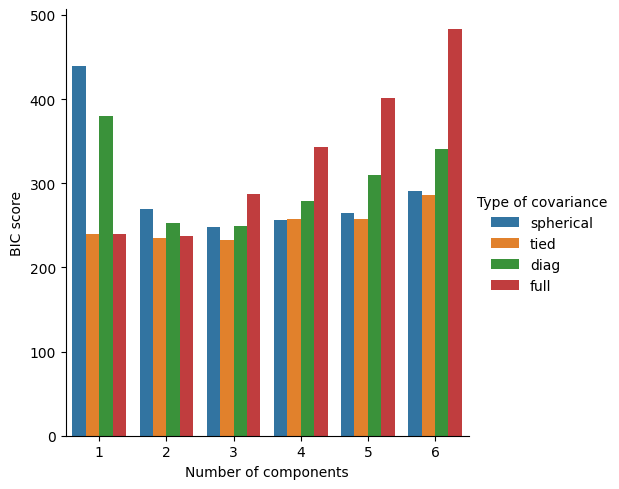

In [ ]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

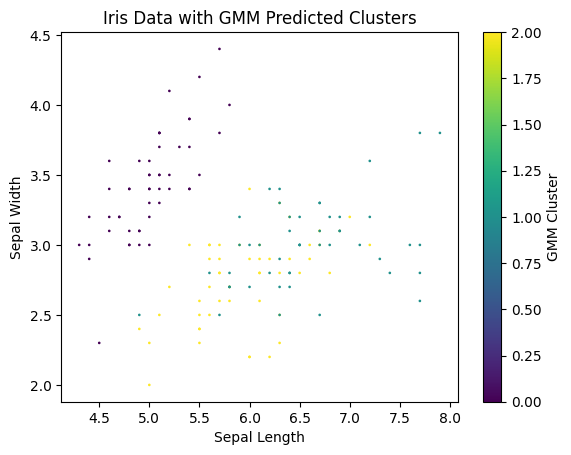

In [ ]:
predicted_clusters = grid_search.predict(iris.data)
plt.scatter(iris.data[:, 0], iris.data[:, 1], c=predicted_clusters, s=0.8, cmap='viridis')
plt.title("Iris Data with GMM Predicted Clusters")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.colorbar(label='GMM Cluster')
plt.show()

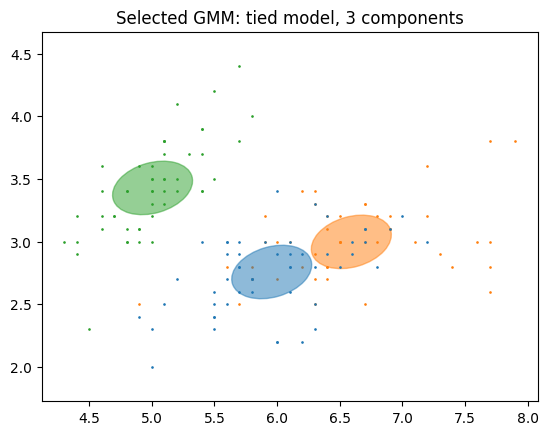

In [ ]:
from matplotlib.patches import Ellipse
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use the number of components from the best estimator
n_components = grid_search.best_estimator_.n_components
color_iter = sns.color_palette("tab10", n_components)[::-1]
Y_ = grid_search.predict(iris.data)
X = iris.data
fig, ax = plt.subplots()

# Get the covariance matrices based on the covariance type
covariances = grid_search.best_estimator_.covariances_
if grid_search.best_estimator_.covariance_type == 'tied':
    covariances = [covariances] * n_components # Repeat the single tied covariance for each component

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        covariances,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(iris.data[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    # Plot the ellipse for each component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()